In [1]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np
import os
import pandas as pd

from tqdm import tqdm
from functools import partial
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
colors = ["#2965CC", "#29A634", "#D99E0B", "#D13913", "#8F398F",
          "#00B3A4", "#DB2C6F", "#9BBF30", "#96622D", "#7157D9"]

Quelques outils pour visualiser les données et les résultats de prédiction.
On cherche notamment à :
* observer la distribution des catégories de l'ensemble d'entrainement
* observer la performance prédictive pour chaque catégorie

# Chargement des données

## Loading...

In [3]:
dataFolder = './challenge_data'
xPath = os.path.join(dataFolder, 'input_train.csv')
yPath = os.path.join(dataFolder,
                     'challenge_output_data_training_file_predict_the_expected_answer.csv')

# Loading, parsing and spliting training and testing data
x = pd.read_csv(xPath, delimiter=';', usecols=[0, 1]).values
y = pd.read_csv(yPath, delimiter=';', usecols=[0, 1]).values

## Global Variables

In [109]:
NUMBER_CATEGORIES = len(set(y[:,1]))
print(NUMBER_CATEGORIES)
STOP_WORDS = ['alors','au','aucuns','aussi','autre','avant','avec','avoir','bon','car',
              'ce','cela','ces','ceux','chaque','ci','comme','comment','dans','des',
              'du','dedans','dehors','depuis','devrait','doit','donc','dos','début','elle',
              'elles','en','encore','essai','est','et','eu','fait','faites','fois',
              'font','hors','ici','il','ils','je','juste','la','le','les',
              'leur','là','ma','maintenant','mais','mes','mine','moins','mon','mot',
              'même','ni','nommés','notre','nous','ou','où','par','parce','pas',
              'peut','peu','plupart','pour','pourquoi','quand','que','quel','quelle','quelles',
              'quels','qui','sa','sans','ses','seulement','si','sien','son','sont',
              'sous','soyez','sujet','sur','ta','tandis','tellement','tels','tes','ton',
              'tous','tout','trop','très','tu','voient','vont','votre','vous','vu',
              'ça','étaient','état','étions','été','être', 'de', 'un', 'une', 'ai', 'ne', 'on']

51


# Distribution du vocabulaire

In [19]:
def parseWord(wordCount, totalWordCount, density, item):
    if density:
        return [item[0], wordCount[0, item[1]] / totalWordCount]
    else:
        return [item[0], wordCount[0, item[1]]]

def vectorizeVocabulary(corpus, verbose=False, density=False):
    # Generate word tokens
    countVectorizer = CountVectorizer(input='content')
    countVector = countVectorizer.fit_transform(corpus)
    vocabulary = countVectorizer.vocabulary_
    wordCount = np.sum(countVector, axis=0)
    totalWordCount = np.sum(wordCount)

    vocabulary = list(map(partial(parseWord, wordCount,
                                  totalWordCount, density), vocabulary.items()))
    
    # Sort words by usage
    sortedVocabulary = sorted(vocabulary, key=lambda x: x[1], reverse=True)
    
    if verbose:
        print("countVector.shape: {}".format(str(countVector.shape)))
        print("wordCount.shape: {}".format(str(wordCount.shape)))
        print(sortedVocabulary[:5])
    
    return sortedVocabulary

In [20]:
def plotVocabulary(vocabulary, numberWords=50):
    labels = [word[0] for word in vocabulary[:numberWords]]
    values = [word[1] for word in vocabulary[:numberWords]]
    yPosition = np.arange(len(labels))

    plt.figure(figsize=(15,8))
    plt.bar(yPosition, values, color=colors[0])
    plt.xticks(yPosition, labels, rotation=90)
    plt.ylabel('Unique count')
    plt.title('Word')

    plt.show()

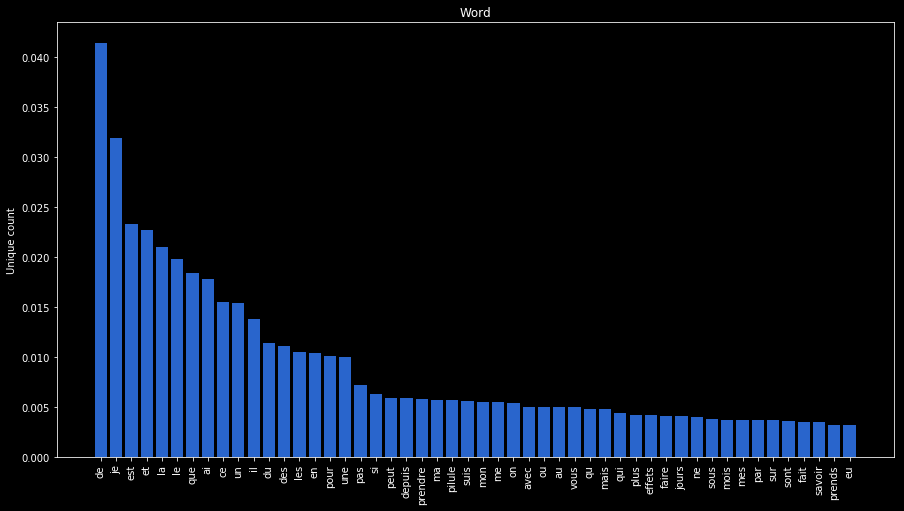

In [21]:
sentences = x[:,1]
sortedVocabulary = vectorizeVocabulary(sentences, verbose=False, density=True)
plotVocabulary(sortedVocabulary)

# Distribution des catégories

In [22]:
countCategories = [0] * NUMBER_CATEGORIES

for point in y:
    countCategories[point[1]] += 1

indexedCountCategories = list(zip(list(range(NUMBER_CATEGORIES)), countCategories))

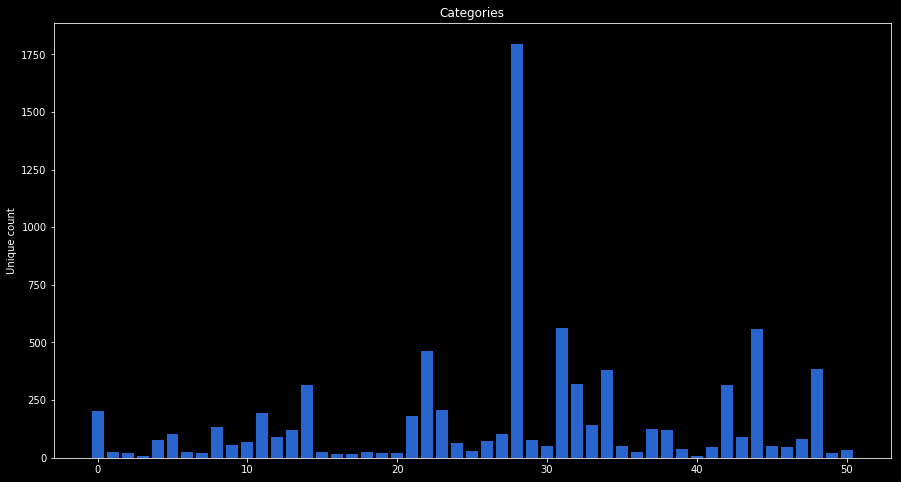

In [23]:
yPosition = np.arange(NUMBER_CATEGORIES)

plt.figure(figsize=(15,8))
plt.bar(yPosition, countCategories, color=colors[0])

plt.ylabel('Unique count')
plt.title('Categories')
axes = plt.gca()
#axes.set_ylim([0,50])
plt.show()

In [24]:
selectedCategories = list(filter(lambda x:  50 < x[1] <= 100, indexedCountCategories))
selectedCategories

[(4, 76),
 (9, 54),
 (10, 68),
 (12, 89),
 (24, 64),
 (26, 72),
 (29, 77),
 (30, 52),
 (43, 91),
 (47, 82)]

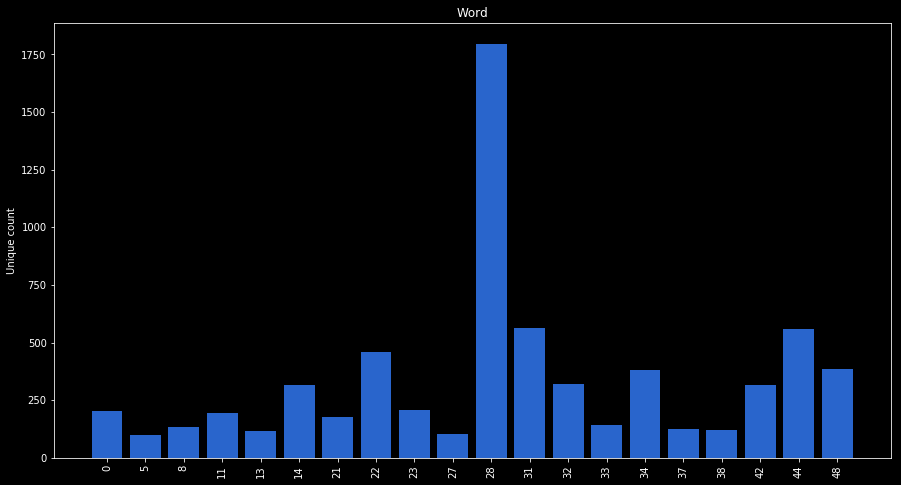

Number of categories with morethan 100 points: 20
Mean of number of points in categories with more than 100 points: 337.0


In [25]:
selectedCategories = list(filter(lambda x: x[1] > 100, indexedCountCategories))

labels = [category[0] for category in selectedCategories]
values = [category[1] for category in selectedCategories]
yPosition = np.arange(len(selectedCategories))

plt.figure(figsize=(15,8))
plt.bar(yPosition, values, color=colors[0])
plt.xticks(yPosition, labels, rotation=90)
plt.ylabel('Unique count')
plt.title('Word')
 
plt.show()

print('Number of categories with more'
      'than 100 points: {}'.format(str(len(selectedCategories))))
print('Mean of number of points in categories with more than 100 points: {}'.format(np.mean([cat[1] for cat in selectedCategories])))

# Distribution du vocabulaire par catégorie

countVector.shape: (104, 822)
wordCount.shape: (1, 822)
[['de', 0.046953046953046952], ['je', 0.033300033300033303], ['et', 0.02763902763902764], ['ai', 0.022311022311022312], ['que', 0.02197802197802198]]


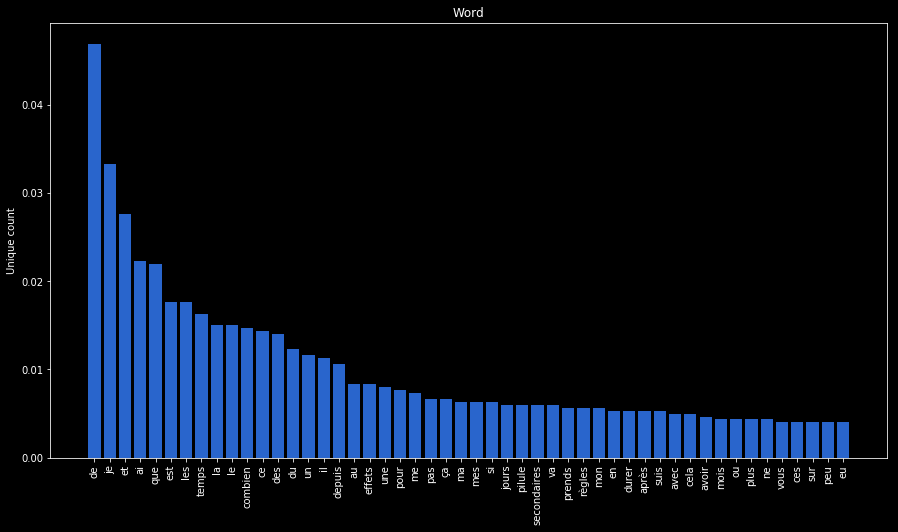

In [26]:
category = 27
selectedSentences = x[y == category][1:]
sortedVocabularyCategory =\
    vectorizeVocabulary(list(map(lambda x: str(x), selectedSentences)),
                        verbose=True, density=True)
plotVocabulary(sortedVocabularyCategory)

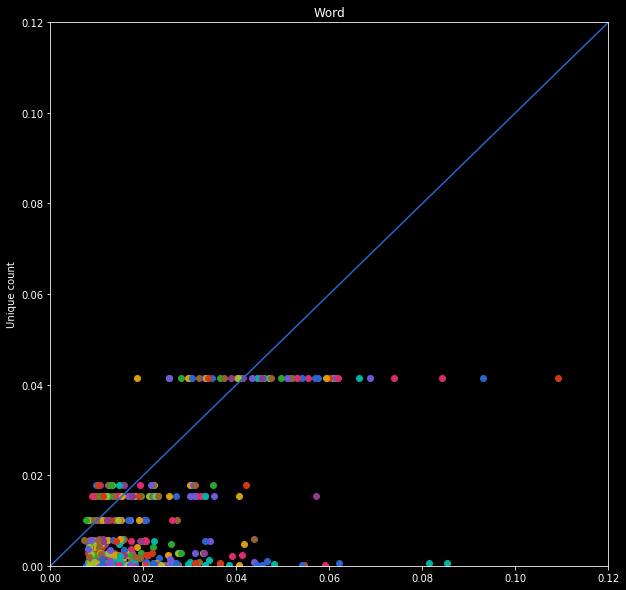

In [27]:
vocabularyDict = dict(sortedVocabulary)
plt.figure(figsize=(10,10))
m = 0
selectedWords = {}

for category in range(NUMBER_CATEGORIES):
    selectedSentences = x[y == category][1:]
    sortedVocabularyCategory = vectorizeVocabulary(list(map(lambda x: str(x),
                                                            selectedSentences)),
                                                   density=True)

    for word in sortedVocabularyCategory[:20]:
        if not word[0] in STOP_WORDS:
            m = max(word[1], m)
            plt.scatter(word[1], vocabularyDict[word[0]],
                        color=colors[category % len(colors)], label=str(category))
            if category in selectedWords:
                selectedWords[category].append([*word, vocabularyDict[word[0]]])
            else:
                selectedWords[category] = [[*word, vocabularyDict[word[0]]]]

plt.plot([0, 1], color=colors[0])
plt.ylim(0, 1.1 * m)
plt.xlim(0, 1.1 * m)
plt.ylabel('Unique count')
plt.title('Word')
plt.show()

In [28]:
selectedWords[:10]

TypeError: unhashable type: 'slice'

# Explore the medicaments names 

In [29]:
MEDICAMENTS = []

with open(os.path.join(dataFolder, 'medicList.txt')) as f:
    for line in f:
        MEDICAMENTS.append(line.lower().rstrip())

print('Liste de médicaments regroupant les libéllés ATC et les'
      'dénominations de spécialité, de taille: {}'.format(len(MEDICAMENTS)))
print('Sample of medicament names: ', MEDICAMENTS[:10])

Liste de médicaments regroupant les libéllés ATC et lesdénominations de spécialité, de taille: 8390
Sample of medicament names:  ['a 313 200  pour cent', 'a 313 50 000 u.i', 'abacavir', 'abacavir/lamivudine', 'abacavir/lamivudine pharma', 'abacavir/lamivudine pharos', 'abamipharm', 'abboticine', 'abelcet', 'abstral']


In [30]:
medicaments_occurences = []
nb_occurences = 0
unique_occurences = []
for xx in tqdm(x):
    occur = []
    for w in xx[1].split():
        w = w.lower()
        if w in MEDICAMENTS:
            occur.append(w)
            nb_occurences +=1
            if w not in unique_occurences:
                unique_occurences.append(w)
    medicaments_occurences.append(occur)
print('{} medicaments occurences in the dataset'.format(nb_occurences))
print('{} unique medicament names occuring in the dataset'.format(len(unique_occurences)))

100%|██████████| 8028/8028 [00:14<00:00, 560.16it/s]

9404 medicaments occurences in the dataset
600 unique medicament names occuring in the dataset


In [48]:
def selectCat(x, y, cat_index, medicaments_occurences = medicaments_occurences):
    cat_ix = []
    for xx, yy in zip(x, y):
        if yy[1] == cat_index:
            cat_ix.append(xx[0])
    cat_ix = np.array(cat_ix)
    selected_questions = x[cat_ix]
    selected_medics = [medicaments_occurences[ix] for ix in cat_ix]
    return selected_questions, selected_medics

In [49]:
cat_index = 40
cat_questions, med_questions = selectCat(x, y, cat_index)
cat_questions

array([[54, 'méthotrexate : origine des composants??'],
       [1317,
        "Un pharmacien souhaite connaître l'origine de l'indigotine composant les gélules de Clamoxyl"],
       [3026,
        "je suis allergique èa la pénicillineet je voudrais savoir est-ce que c'est vrai que la pénicilline est fait a base d'urine de jument?"],
       [4956,
        "Un patient se demande d'où vient le principe actif de Permixon ?"],
       [7592,
        "Une patiente souhaite connaître l'origine du Dextran70 présent dans le Vogalène Lyoc et l'Imodium Lyoc"],
       [7827, 'cotareg ? Origine animale des excipients?'],
       [7944, 'prometrium, progesterone naturelle?? vrai?']], dtype=object)

In [33]:
# try to see if there is a correletation between medicament names and the categories
meds_by_category = {}
for cat in set(y[:,1]):
    meds_by_category[cat] = []
    
for yy, meds in zip(y, medicaments_occurences):
    for med in meds:
        if med not in meds_by_category[yy[1]]:
            meds_by_category[yy[1]].append(med)

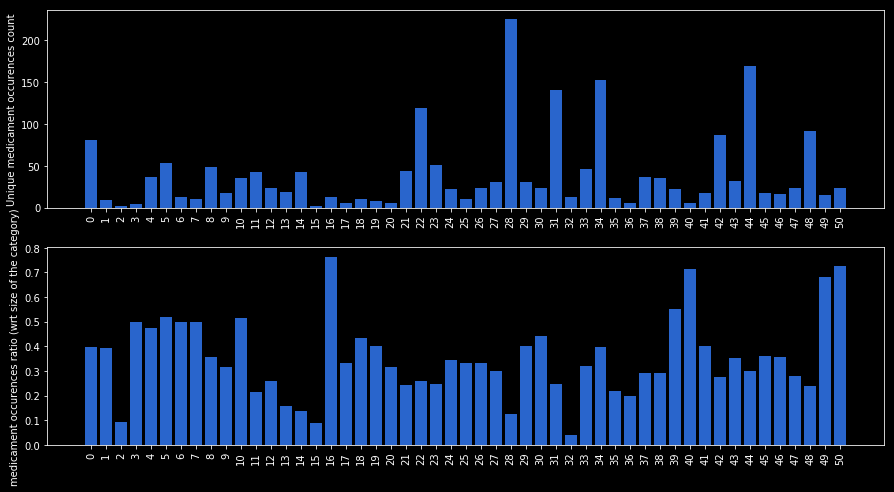

In [34]:
labels = [nb_cat for nb_cat in np.arange(NUMBER_CATEGORIES)]
values = [len(meds_cat) for meds_cat in list(meds_by_category.values())]
ratio_values = [v/l for (v, l) in zip(values, countCategories)]
yPosition = np.arange(NUMBER_CATEGORIES)

plt.figure(figsize=(15,8))
plt.title('Divesity of medicament names in the different categories')
plt.subplot(211)
plt.bar(yPosition, values, color=colors[0])
plt.xticks(yPosition, labels, rotation=90)
plt.ylabel('Unique medicament occurences count')

plt.subplot(212)
plt.bar(yPosition, ratio_values, color=colors[0])
plt.xticks(yPosition, labels, rotation=90)
plt.ylabel('medicament occurences ratio (wrt size of the category)')

plt.show()

# Explore the variety of questions

In [35]:
cat_index = 46
cat_questions, med_questions = selectCat(x, y, cat_index)
cat_questions[:10]

array([[56,
        'le prix du générique lisinopril 20mg est passé subitement de 12,39€ à 13,25€ , est ce normal?'],
       [75, 'je souhaiterais savoir quel est le prix du vermifuge humain ?'],
       [457,
        'je voudrais commencer une cure de cystine b6. j ai entendu dire qu en france le prix etait de 3 € ?'],
       [484,
        "j'ai arrêté cycléane 20 il y a 4 ans et là j'attends mes règles pour pouvoir la reprendre. je voudrais savoir combien coûtent les 3 plaquettes maintenant ?"],
       [703,
        'obligé de payer mon rivotril 50 euros la bouteille , normal ?'],
       [1003, 'cérazette ? Combien ça coûte ?'],
       [1047,
        'obligé de payer mon rivotril 50 euros la bouteille , normal ?'],
       [1091, 'tarif trinordiol?'],
       [1602, 'Quel est le prix du générique biogaran de mercilon ?'],
       [1718, 'prix cycléane 20 ?']], dtype=object)

### See short questions

In [38]:
min_length = 15
short_questions = []
for xx in x:
    if len(xx[1]) <= min_length:
        short_questions.append((xx[1], y[xx[0],1]))

In [39]:
short_questions[:10]

[('urbanyl?', 22),
 ('deroxat ??', 22),
 ('C quoi neisvac?', 22),
 ('REJET', 14),
 ('neoral', 22),
 ('norset', 22),
 ('optilova 20 ?', 22),
 ('la damiana?', 22),
 ('méningitec ?', 22),
 ('exacyl ??', 22)]

### Extract important vocabulary for each category

In [112]:
def extract_top_k(x, y, k, stop_words = STOP_WORDS):
    best_vocab = []
    nb_cat = len(set(y[:,1]))
    for cat in np.arange(nb_cat):
        questions = selectCat(x, y, cat)[0][:,1]
        cat_vocab = vectorizeVocabulary(corpus=questions)
        cat_best_vocab = []
        for w in cat_vocab:
            if len(cat_best_vocab) < k:
                if w[0] not in stop_words:
                    cat_best_vocab.append(w)           
        best_vocab.append(cat_best_vocab)
    return best_vocab

In [113]:
best_vocab = extract_top_k(x, y, 10)

In [151]:
ix = 17
best_vocab[ix]

[['vaccin', 9],
 ['température', 6],
 ['frigo', 5],
 ['ambiante', 4],
 ['était', 3],
 ['qu', 3],
 ['risques', 3],
 ['réfrigérateur', 3],
 ['heures', 3],
 ['utiliser', 3]]

In [152]:
questions = selectCat(x, y, ix)[0]
print('{} questions in class {}'.format(len(questions),ix))
print(questions[:10])

15 questions in class 17
[[467 'vaccin Prévenar réchauffé : inefficace ou plus risqué?']
 [694
  "je voulais savoir quel étaient les risques pour l'enfant lorsque le vaccin était mal conservé?"]
 [726
  "J'ai gardé le vaccin ROR 14 heures à température ambiante : peut-on quand même le faire ?"]
 [886
  'Une pharmacienne souhaite savoir si elle peut utiliser le Xolair qui était conservé dans un frigo qui est monté à 12°C pendant au maximum 12 heures ?']
 [1001
  'Mon vaccin contre la fièvre jaune est resté 2 jours hors du frigo, est-i toujours utilisable ?']
 [1454
  "rotateq prevenar pentavac périmés ? le fait d'avoir passé 20 heures à température ambiante rend-il les vaccins inutilisables?"]
 [1999
  "Mon réfrigérateur est tombé en panne une nuit entière avec Copaxone à l'intérieur et la température maximale atteinte a été de 15°C. Puis-je encore l'utiliser ?"]
 [2116
  "mon fils est sous pediazole. je viens de m'aperçevoir qu'une fois ouvert il faut le conserver au frigo. quel est le